In [0]:
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass

from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras

# Вспомогательные библиотеки
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [0]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_small.tar.gz


In [0]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [0]:
# task 3
# Разделите данные на три подвыборки: 
# обучающую (200 тыс. изображений),
# валидационную (10 тыс. изображений)
# и контрольную (тестовую) (19 тыс. изображений);
def split_dataset(dataset):
    learn_dataset = dataset[0:450000]
    print(len(learn_dataset))
    test_dataset = dataset[450001:461955]
    print(len(test_dataset))
    return learn_dataset,test_dataset

def randomize_list(dataset):
    from random import shuffle
    shuffle(dataset)
    return dataset

from tqdm import tqdm
import hashlib
def md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def get_all_files_recursively(path):
    return [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames]

def remove_dublicates(dataset):
    dublicate_remover = dict()
    for file in dataset:
        dublicate_remover[md5(file)] = file
    return list(dublicate_remover.values())

dataset = get_all_files_recursively("notMNIST_large")
# task 4

# Проверьте, что данные из обучающей выборки не пересекаются 
# с данными из валидационной и контрольной выборок. 
# Другими словами, избавьтесь от дубликатов в обучающей выборке.
dataset = remove_dublicates(dataset)
print(len(dataset))
dataset = randomize_list(dataset)
learn_dataset,test_dataset = split_dataset(dataset)

461955
450000
11954


In [0]:
learn_dataset[0]

'notMNIST_large/A/RWtsZWt0aWMgTm9ybWFsLnR0Zg==.png'

In [0]:
from sklearn.linear_model import LogisticRegression
# from tqdm.notebook import tqdm
import numpy as np
from PIL import Image

alphabet = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9}
class_names = "ABCDEFGHIJ"
# def Learn(X_train, y_train, X_test, y_test):
#     clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#     predicted = clf.predict(X_test)
#     score = clf.score(X_test, y_test) 
#     print(score)
#     return score

def GetClassData(path):
    return alphabet[path.split("/")[1]]


def GetLearnData(learn_dataset, test_dataset, train_len=len(learn_dataset)):
    X_train, y_train, X_test, y_test = [],[],[],[] 
    for index in tqdm(range(train_len)):
        path = learn_dataset[index]
        try:
            img = Image.open(path)
        except:
            continue
        arr = np.array(img)
        X_train.append(arr)
        y_train.append(GetClassData(path))
    for path in tqdm(test_dataset):
        try:
            img = Image.open(path)
        except:
            continue
        arr = np.array(img)
        X_test.append(arr)
        y_test.append(GetClassData(path))
    return (X_train, y_train), (X_test, y_test)


(train_images, train_labels), (test_images, test_labels)  = GetLearnData(learn_dataset, test_dataset)


In [0]:
train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

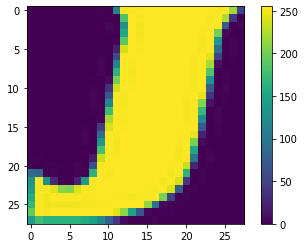

In [0]:
plt.imshow(train_images[0])
plt.colorbar()
# plt.grid(False)
plt.show()

In [0]:
train_images = train_images / 255.0
test_images = test_images / 255.0

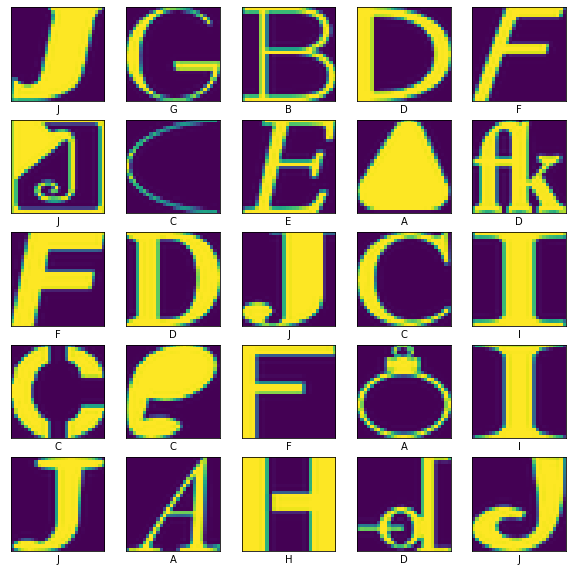

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [0]:
# 1 скрытый слой
# функция активации кусочно-линейная
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [0]:
# стохастический градиент
model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(train_images, train_labels, epochs=10)

Train on 449998 samples
Epoch 1/10
449998/449998 [==============================] - 31s 70us/sample - loss: 0.6139 - accuracy: 0.8269
Epoch 2/10
449998/449998 [==============================] - 32s 71us/sample - loss: 0.4924 - accuracy: 0.8567
Epoch 3/10
449998/449998 [==============================] - 32s 71us/sample - loss: 0.4501 - accuracy: 0.8686
Epoch 4/10
449998/449998 [==============================] - 31s 70us/sample - loss: 0.4249 - accuracy: 0.8765
Epoch 5/10
449998/449998 [==============================] - 31s 69us/sample - loss: 0.4074 - accuracy: 0.8815
Epoch 6/10
449998/449998 [==============================] - 31s 70us/sample - loss: 0.3943 - accuracy: 0.8853
Epoch 7/10
449998/449998 [==============================] - 31s 70us/sample - loss: 0.3836 - accuracy: 0.8880
Epoch 8/10
449998/449998 [==============================] - 30s 68us/sample - loss: 0.3746 - accuracy: 0.8907
Epoch 9/10
449998/449998 [==============================] - 31s 68us/sample - loss: 0.3670 - acc

In [0]:
# точность при логистческой регрессии = 0.80
# задание 2
# Как улучшилась точность классификатора по сравнению с логистической регрессией?

In [0]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nТочность данной нейронной сети:', test_acc)

11954/11954 - 0s - loss: 0.3872 - accuracy: 0.8890

Точность данной нейронной сети: 0.8889911


In [0]:
# задание 3
# Используйте регуляризацию и метод сброса нейронов (dropout) для борьбы с переобучением. Как улучшилось качество классификации?

from keras import regularizers

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nТочность нейронной сети с регуляризацией и сбросом нейронов:', test_acc)

Train on 449998 samples
Epoch 1/10
449998/449998 [==============================] - 47s 105us/sample - loss: 1.1377 - accuracy: 0.8052
Epoch 2/10
449998/449998 [==============================] - 46s 103us/sample - loss: 0.6662 - accuracy: 0.8303
Epoch 3/10
449998/449998 [==============================] - 47s 105us/sample - loss: 0.6428 - accuracy: 0.8359
Epoch 4/10
449998/449998 [==============================] - 47s 104us/sample - loss: 0.6309 - accuracy: 0.8385
Epoch 5/10
449998/449998 [==============================] - 47s 105us/sample - loss: 0.6229 - accuracy: 0.8415
Epoch 6/10
449998/449998 [==============================] - 48s 106us/sample - loss: 0.6184 - accuracy: 0.8429
Epoch 7/10
449998/449998 [==============================] - 47s 104us/sample - loss: 0.6154 - accuracy: 0.8439
Epoch 8/10
449998/449998 [==============================] - 46s 102us/sample - loss: 0.6124 - accuracy: 0.8450
Epoch 9/10
449998/449998 [==============================] - 46s 102us/sample - loss: 0.6

In [0]:
# задание 4
# Воспользуйтесь динамически изменяемой скоростью обучения (learning rate). 
# Наилучшая точность, достигнутая с помощью данной модели составляет 97.1%. 
# Какую точность демонстрирует Ваша реализованная модель?

from keras import regularizers

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



# Set Model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dense(10, activation='softmax')
])

# Set Optimizer
opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)



model.fit(train_images, train_labels, epochs=10)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nТочность нейронной сети с регуляризацией, сбросом нейронов и динамически изменяемой скоростью обучения:', test_acc)


Train on 449998 samples
Epoch 1/10
449998/449998 [==============================] - 50s 110us/sample - loss: 0.9012 - accuracy: 0.7996
Epoch 2/10
449998/449998 [==============================] - 48s 107us/sample - loss: 0.8643 - accuracy: 0.8036
Epoch 3/10
449998/449998 [==============================] - 47s 105us/sample - loss: 0.8626 - accuracy: 0.8041
Epoch 4/10
449998/449998 [==============================] - 47s 106us/sample - loss: 0.8594 - accuracy: 0.8040
Epoch 5/10
449998/449998 [==============================] - 46s 103us/sample - loss: 0.8539 - accuracy: 0.8049
Epoch 6/10
449998/449998 [==============================] - 45s 101us/sample - loss: 0.8517 - accuracy: 0.8050
Epoch 7/10
449998/449998 [==============================] - 46s 103us/sample - loss: 0.8515 - accuracy: 0.8047
Epoch 8/10
449998/449998 [==============================] - 46s 103us/sample - loss: 0.8484 - accuracy: 0.8052
Epoch 9/10
449998/449998 [==============================] - 47s 104us/sample - loss: 0.8